In this notebook we analyse the stability of the layer conductance values from the model on a fixed train and test set. We are interested in how the random initialization of the weights influences the importance scores obtained for the genes.

Imports:

In [1]:
import pnet_loader
import util
import Pnet
import ReactomeNetwork
import torch
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch.nn as nn
from scipy.stats import bernoulli
import networkx as nx

%load_ext autoreload
%autoreload 2

Data Loading:

In [2]:
prostate_mutations = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_cnv = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_response = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/response_paper.csv')
prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv('/mnt/disks/pancan/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

# prostate_mutations = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
# prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_cnv = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
# prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
# prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_response = pd.read_csv('../../data/pnet_database/prostate/processed/response_paper.csv')
# prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
# prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_genes = pd.read_csv('../../data/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
# prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

prostate_cnv = prostate_cnv[prostate_genes].copy()
prostate_mutations = prostate_mutations[prostate_genes].copy()

# prostate_genes = util.select_highly_variable_genes(prostate_mutations)
# prostate_genes = prostate_genes['level_1']
prostate_mutations = prostate_mutations[list(set(prostate_mutations.columns).intersection(prostate_genes))].copy()
prostate_cnv = prostate_cnv[list(set(prostate_cnv.columns).intersection(prostate_genes))].copy()

# Regenerate input as specified in prostate_paper
prostate_mutations = (prostate_mutations > 0).astype(int)
prostate_amp = (prostate_cnv > 1).astype(int)
prostate_del = (prostate_cnv < -1).astype(int)

In [3]:
genetic_data = {'mut': prostate_mutations, 'amp': prostate_amp, 'del': prostate_del}

In [4]:
test_inds = list(pd.read_csv('/mnt/disks/pancan/pnet_database/splits/test_set.csv')['id'])
train_inds = list(pd.read_csv('/mnt/disks/pancan/pnet_database/splits/training_set.csv')['id'])

In [5]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

Model training:

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (807, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
shuffling 807 labels
shuffling 102 labels
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (807, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
shuffling 807 labels
shuffling 102 labels
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
F

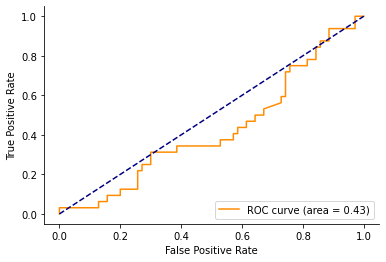

In [6]:
for i in range(50):
    random_response = bernoulli.rvs(prostate_response.mean().values[0], size=prostate_response.shape[0])
    random_response = pd.DataFrame({'response': random_response}, index=prostate_response.index)
    class_weights = util.get_class_weights(torch.tensor(random_response.values).view(-1))
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, random_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/label_shuffle/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes,
                                                                            shuffle_labels=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/label_shuffle/run{}'.format(i))

In [8]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, prostate_response, gene_set=canc_genes)

reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (708, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (303, 1329)
Found 443 overlapping genes


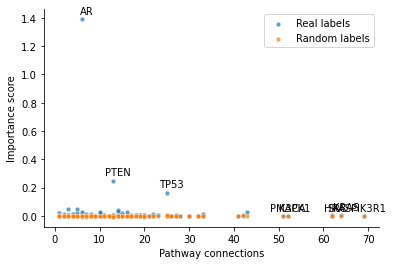

In [10]:
df_imps = pd.DataFrame()
df_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/label_shuffle/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    # imps = imps.mean()
    ranks = imps.rank(ascending=False)
    df_imps['run{}'.format(i)] = imps
    df_ranks['run{}'.format(i)] = ranks

df_imps_prostate = pd.DataFrame()
df_ranks_prostate = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    # imps = imps.mean()
    ranks = imps.rank(ascending=False)
    df_imps_prostate['run{}'.format(i)] = imps
    df_ranks_prostate['run{}'.format(i)] = ranks
    
plotting_df = pd.DataFrame()
plotting_df['random_imps'] = df_imps.mean(axis=1)
plotting_df['prostate_imps'] = df_imps_prostate.mean(axis=1)
plotting_df['node_out_edges'] = pd.concat([l.sum(axis=1)for l in reactome_network.gene_layers], axis=1).sum(axis=1)

sns.scatterplot(data=plotting_df, x='node_out_edges', y='prostate_imps', s=20, alpha=0.7)
for index, row in plotting_df.iterrows():
    if abs(row['prostate_imps']) > 0.1:
        plt.annotate(index, (row['node_out_edges'], row['prostate_imps']), textcoords="offset points", xytext=(5,5), ha='center')
        
sns.scatterplot(data=plotting_df, x='node_out_edges', y='random_imps', s=20, alpha=0.7)
for index, row in plotting_df.iterrows():
    if abs(row['random_imps']) > 0.1:
        plt.annotate(index, (row['node_out_edges'], row['random_imps']), textcoords="offset points", xytext=(5,5), ha='center')
    if row['node_out_edges'] > 50:
        plt.annotate(index, (row['node_out_edges'], row['random_imps']), textcoords="offset points", xytext=(5,5), ha='center')

sns.despine()
plt.legend(['Real labels', 'Random labels'])
plt.ylabel('Importance score')
plt.xlabel('Pathway connections')
plt.savefig('../figures/gene_imp_vs_connections.pdf')
plt.show()

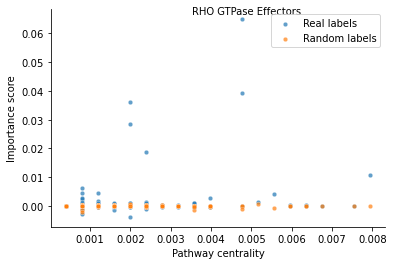

In [14]:
df_imps = pd.DataFrame()
df_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/label_shuffle/run{}/layer_1_importances.csv'.format(i)).set_index('Unnamed: 0')
    # imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    imps = imps.mean()
    ranks = imps.rank(ascending=False)
    df_imps['run{}'.format(i)] = imps
    df_ranks['run{}'.format(i)] = ranks
df_imps = df_imps.loc[[i for i in df_imps.index if i.split('.')[-1] != '1']]
    
df_imps_prostate = pd.DataFrame()
df_ranks_prostate = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val/run{}/layer_1_importances.csv'.format(i)).set_index('Unnamed: 0')
    # imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    imps = imps.mean()
    ranks = imps.rank(ascending=False)
    df_imps_prostate['run{}'.format(i)] = imps
    df_ranks_prostate['run{}'.format(i)] = ranks
df_imps_prostate = df_imps_prostate.loc[[i for i in df_imps.index if i.split('.')[-1] != '1']]    

centrality_df = pd.DataFrame.from_dict(nx.degree_centrality(reactome_network.graph), orient='index')
enc_dict = reactome_network.pathway_encoding.set_index('ID')['pathway']
enc_dict['root'] = 'root'
centrality_df.index = centrality_df.index.map(lambda x: enc_dict[x])
centrality_df = centrality_df[~centrality_df.index.duplicated(keep='first')]
    
plotting_df = pd.DataFrame()
plotting_df['random_imps'] = df_imps.mean(axis=1)
plotting_df['prostate_imps'] = df_imps_prostate.mean(axis=1)
plotting_df['centrality'] = centrality_df.loc[plotting_df.index]

sns.scatterplot(data=plotting_df, x='centrality', y='prostate_imps', s=20, alpha=0.7)
for index, row in plotting_df.iterrows():
    if abs(row['prostate_imps']) > 0.05:
        plt.annotate(index, (row['centrality'], row['prostate_imps']), textcoords="offset points", xytext=(5,5), ha='center')
        
sns.scatterplot(data=plotting_df, x='centrality', y='random_imps', s=20, alpha=0.7)
for index, row in plotting_df.iterrows():
    if abs(row['random_imps']) > 0.05:
        plt.annotate(index, (row['centrality'], row['random_imps']), textcoords="offset points", xytext=(5,5), ha='center')
    if row['centrality'] > 0.02:
        plt.annotate(index, (row['centrality'], row['random_imps']), textcoords="offset points", xytext=(5,5), ha='center')

sns.despine()
plt.legend(['Real labels', 'Random labels'])
plt.ylabel('Importance score')
plt.xlabel('Pathway centrality')
plt.savefig('../figures/layer1_imp_vs_connections.pdf')
plt.show()

In [64]:
pathway_dict = model.reactome_network.pathway_encoding.set_index('ID')['pathway'].to_dict()

In [65]:
reactome_graph = model.reactome_network.graph